#Libraries

In [78]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import umap
import gseapy as gp
from IPython.display import display
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
import xgboost as xgb
import shap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score

from itertools import combinations
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


#Data Preparation

In [46]:
DATA_DIR = Path(os.getenv("DATA_DIR", "./Dataset"))
DATA_DIR.mkdir(parents=True, exist_ok=True)

data_path = DATA_DIR / "LUSCexpfile.csv" 

column_headers = pd.read_csv(data_path, sep=';', header=None, nrows=1).iloc[0, 1:].tolist()
sample_types_list = pd.read_csv(data_path, sep=';', header=None, skiprows=1, nrows=1).iloc[0, 1:].tolist()
sample_types = pd.Series(sample_types_list, index=column_headers)
df_expr = pd.read_csv(data_path, sep=';', header=None, skiprows=2, index_col=0)
df_expr.columns = column_headers

print("Initial shape (Genes x Samples):", df_expr.shape)
print("\nSample types extracted successfully:")
print(sample_types.value_counts())



Initial shape (Genes x Samples): (56907, 551)

Sample types extracted successfully:
tumor     502
normal     49
Name: count, dtype: int64


In [48]:
df_expr = df_expr.groupby(df_expr.index).mean()
print(f"Shape after aggregating duplicate genes: {df_expr.shape}")
df_expr = df_expr.astype(float)

#Filter out genes with low variance across samples
variances = df_expr.var(axis=1)
top_genes_indices = variances.nlargest(10000).index
df_filtered = df_expr.loc[top_genes_indices]
print("Shape after filtering for high-variance genes:", df_filtered.shape)

#Log2 transform the data: log2(TPM + 1)
df_log_transformed = np.log2(df_filtered + 1)

#Normalize per sample using z-score
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_log_transformed.T),
                             index=df_log_transformed.columns,
                             columns=df_log_transformed.index)

print("\nFinal prepared data shape (Samples x Genes):", df_normalized.shape)

Shape after aggregating duplicate genes: (55430, 551)
Shape after filtering for high-variance genes: (10000, 551)

Final prepared data shape (Samples x Genes): (551, 10000)


#Exploratory Data Analysis

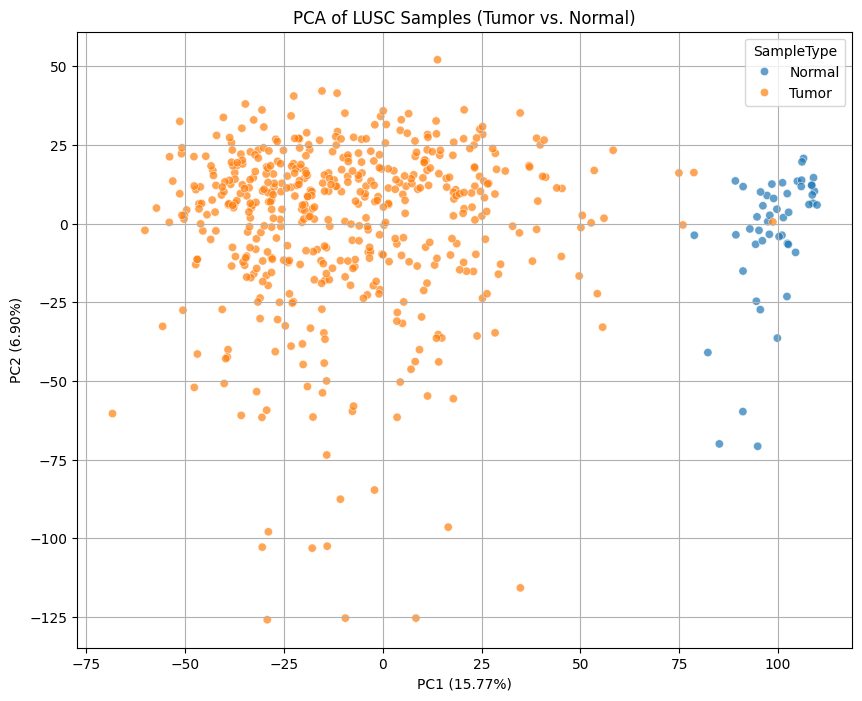

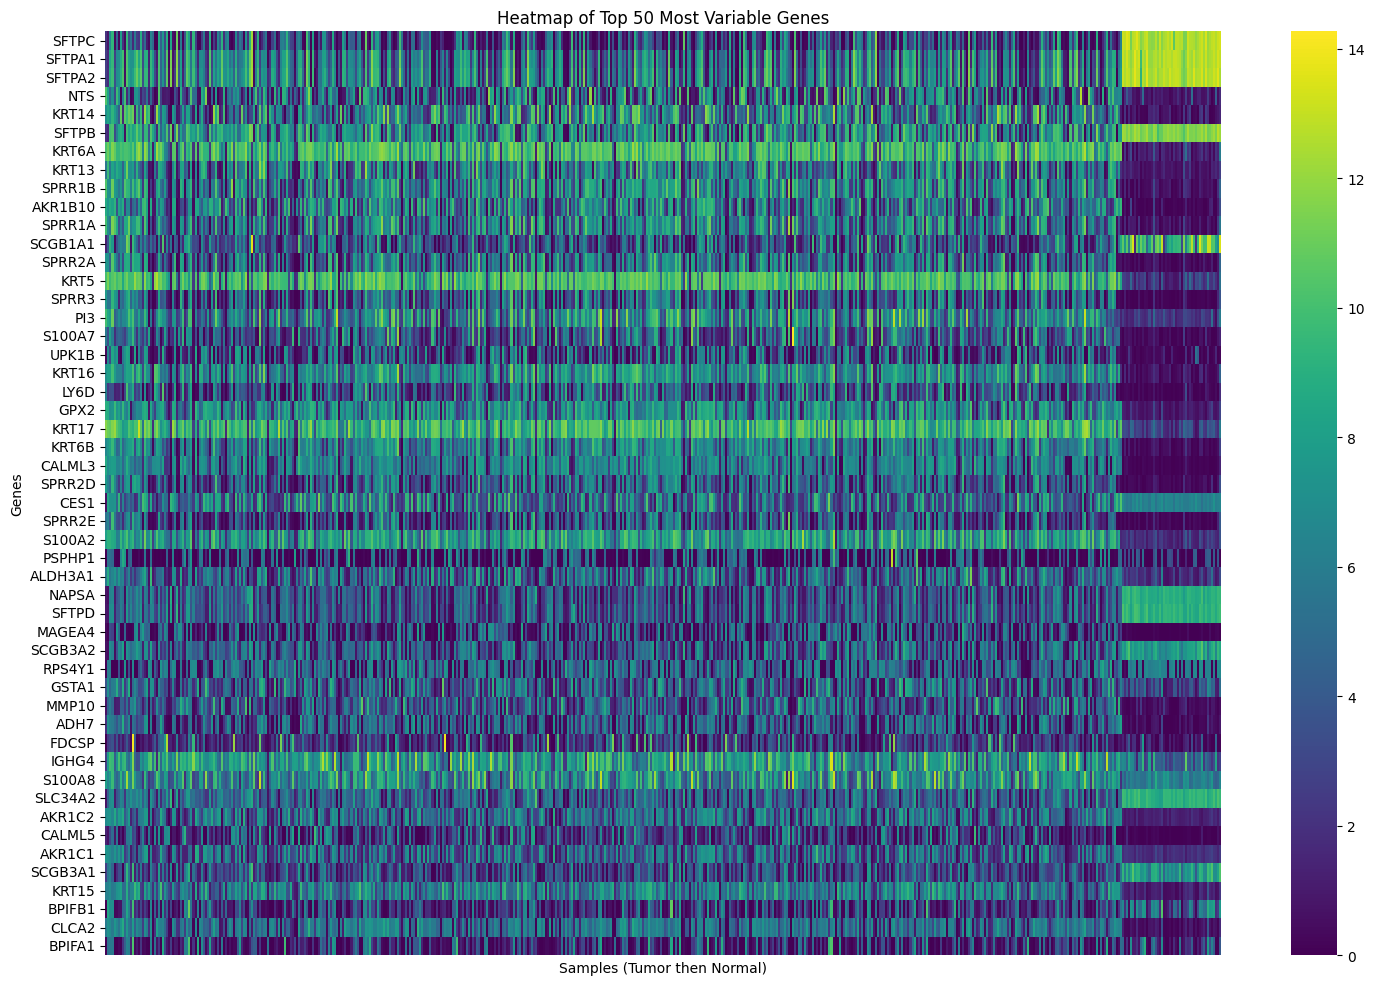

In [49]:
# a. PCA to visualize sample distributions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_normalized)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df_normalized.index)
pc_df['SampleType'] = sample_types.str.capitalize() 

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='SampleType', data=pc_df, alpha=0.7)
plt.title('PCA of LUSC Samples (Tumor vs. Normal)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.grid(True)
plt.show()

# b. Heatmap of top varying genes
top_varying_genes = df_log_transformed.var(axis=1).nlargest(50).index

tumor_samples = df_log_transformed.loc[top_varying_genes, sample_types[sample_types == 'tumor'].index]
normal_samples = df_log_transformed.loc[top_varying_genes, sample_types[sample_types == 'normal'].index]
heatmap_data = pd.concat([tumor_samples, normal_samples], axis=1)

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=False)
plt.title('Heatmap of Top 50 Most Variable Genes')
plt.xlabel('Samples (Tumor then Normal)')
plt.ylabel('Genes')
plt.show()

#Differential Expression Analysis

Found 2709 differentially expressed genes.


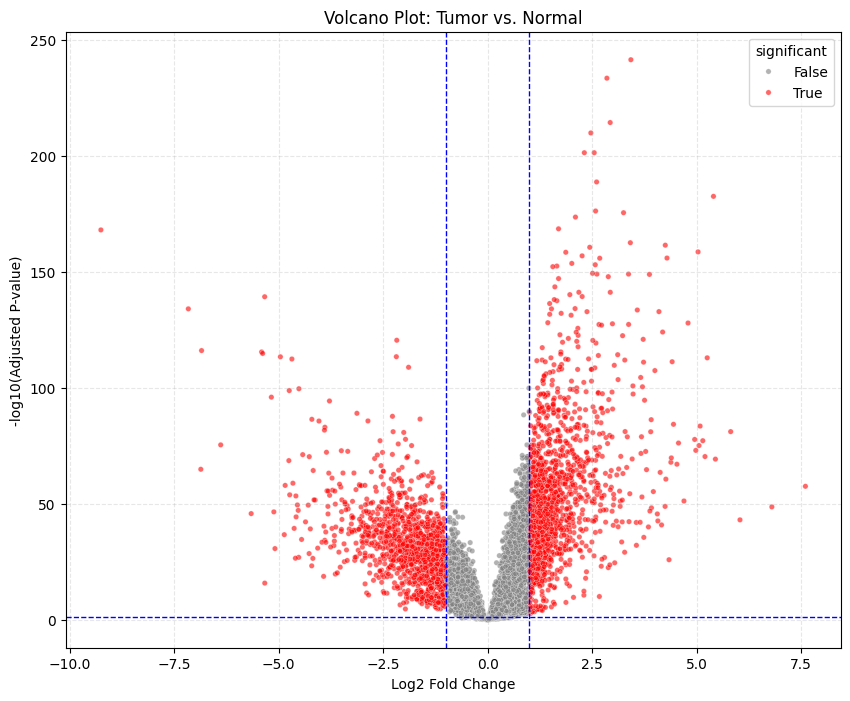

In [50]:
tumor_data = df_log_transformed.loc[:, sample_types[sample_types == 'tumor'].index]
normal_data = df_log_transformed.loc[:, sample_types[sample_types == 'normal'].index]

# Perform t-test for each gene
p_values = []
log2_fold_changes = []

for gene in df_log_transformed.index:
    tumor_expr = tumor_data.loc[gene]
    normal_expr = normal_data.loc[gene]
    
    # t-test
    stat, p_val = ttest_ind(tumor_expr, normal_expr, equal_var=False, nan_policy='omit') 
    p_values.append(p_val)
    
    # Log2 Fold Change
    log2fc = tumor_expr.mean() - normal_expr.mean()
    log2_fold_changes.append(log2fc)

# Create a results DataFrame
de_results = pd.DataFrame({
    'log2FC': log2_fold_changes,
    'p_value': p_values
}, index=df_log_transformed.index)

# Remove any potential NaN p-values
de_results.dropna(subset=['p_value'], inplace=True)

# Adjust for multiple testing using Benjamini-Hochberg
de_results['FDR'] = fdrcorrection(de_results['p_value'])[1]

# Identify significant DEGs (Differentially Expressed Genes)
de_results['significant'] = (de_results['FDR'] < 0.05) & (abs(de_results['log2FC']) > 1)

print(f"Found {de_results['significant'].sum()} differentially expressed genes.")

# Visualize DEGs: Volcano Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='log2FC', 
    y=-np.log10(de_results['FDR']), 
    hue='significant', 
    data=de_results, 
    palette={True: 'red', False: 'grey'}, 
    alpha=0.6,
    s=15
)
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', lw=1)
plt.axvline(x=1, color='blue', linestyle='--', lw=1)
plt.axvline(x=-1, color='blue', linestyle='--', lw=1)
plt.title('Volcano Plot: Tumor vs. Normal')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(Adjusted P-value)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [54]:
# Get the list of significant gene names
significant_genes = de_results[de_results['significant']].index.tolist()

# Run enrichment analysis (with the 'description' argument removed)
enriched_pathways = gp.enrichr(gene_list=significant_genes,
                               gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
                               organism='human',
                               outdir=None)

# Display top pathways
display(enriched_pathways.results.head())

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Staphylococcus aureus infection,44/95,9.303308e-15,2.939845e-12,0,0,5.581135,180.317586,C1QB;CFD;C1QA;ITGAM;SELPLG;ITGB2;C5AR1;CFI;PTA...
1,KEGG_2021_Human,Cell adhesion molecules,55/148,4.231315e-13,6.685477e-11,0,0,3.832276,109.185731,CD86;CNTNAP2;ITGAM;ITGB2;ICAM2;PTPRM;ITGAL;CLD...
2,KEGG_2021_Human,Cell cycle,46/124,3.675693e-11,3.871730e-09,0,0,3.811963,91.588860,CDKN1C;HDAC2;PCNA;MCM7;PRKDC;HDAC1;BUB1B;TTK;P...
3,KEGG_2021_Human,Viral myocarditis,27/60,2.963452e-09,2.102879e-07,0,0,5.264796,103.384323,CD86;LAMA2;LAMA1;ITGB2;PRF1;ITGAL;ICAM1;HLA-DM...
4,KEGG_2021_Human,DNA replication,20/36,3.327340e-09,2.102879e-07,0,0,8.030402,156.762215,RFC5;PRIM2;FEN1;RFC3;PCNA;RNASEH2A;RFC4;MCM7;L...


#Cancer Subtyping

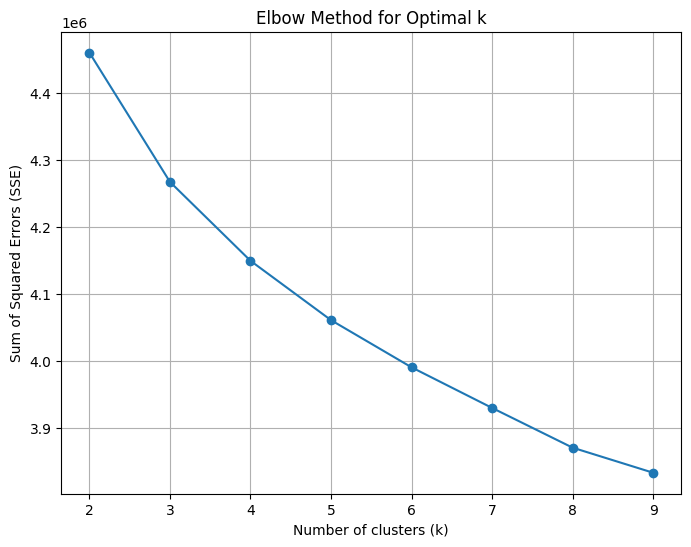

In [56]:
# We'll use the normalized data for tumors only
tumor_normalized_df = df_normalized[sample_types == 'tumor']

# a. Determine optimal number of clusters (k)
# Elbow Method
sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(tumor_normalized_df)
    sse[k] = kmeans.inertia_ 

plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

/var/folders/6c/shw2d6815h91z5snfwyx87p40000gn/T/ipykernel_53691/3285583090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_normalized_df['Cluster'] = cluster_labels
/Users/princesingh/Documents/TCGA/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


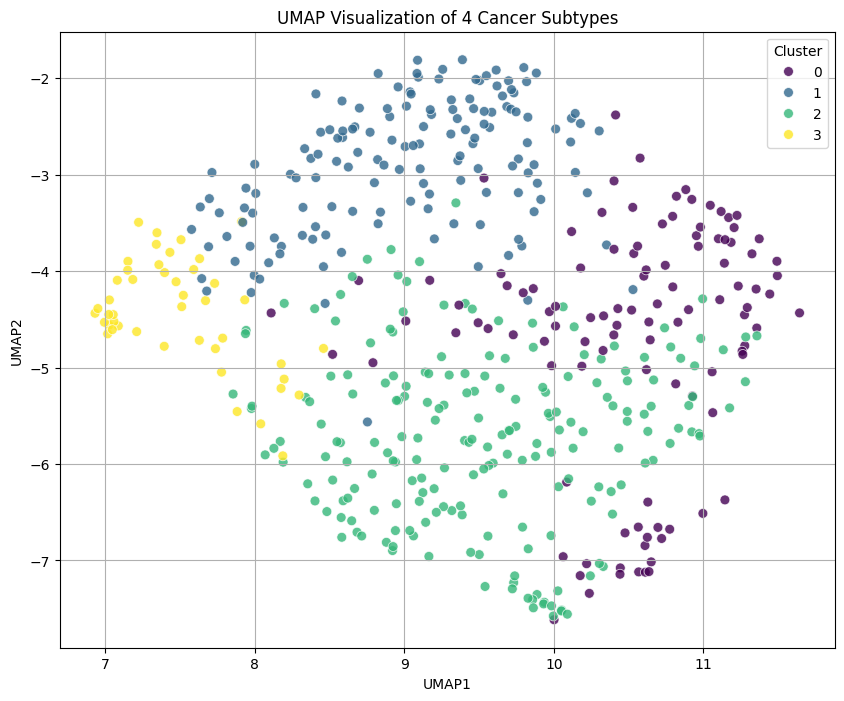

In [58]:
OPTIMAL_K = 4

# b. Perform K-Means clustering
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(tumor_normalized_df)

# Add cluster labels to our tumor data
tumor_normalized_df['Cluster'] = cluster_labels

# c. Visualize clusters using UMAP (often better than PCA for cluster visualization)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(tumor_normalized_df.drop('Cluster', axis=1))
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=tumor_normalized_df.index)
umap_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', data=umap_df, palette='viridis', s=50, alpha=0.8)
plt.title(f'UMAP Visualization of {OPTIMAL_K} Cancer Subtypes')
plt.grid(True)
plt.show()

#Biomarker Discovery for Subtypes


 Biomarkers for Cluster 0:
Top 5 upregulated genes in Cluster 0:
            p_value    log2FC           FDR
0                                          
H19    2.981392e-06  1.470440  1.325063e-05
PADI3  1.048713e-08  1.442010  7.716799e-08
ADH1C  7.673362e-05  1.296833  2.570306e-04
FOXA1  8.088854e-12  1.236561  1.210906e-10
FGFR3  4.705100e-10  1.132004  4.695709e-09


/Users/princesingh/Documents/TCGA/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


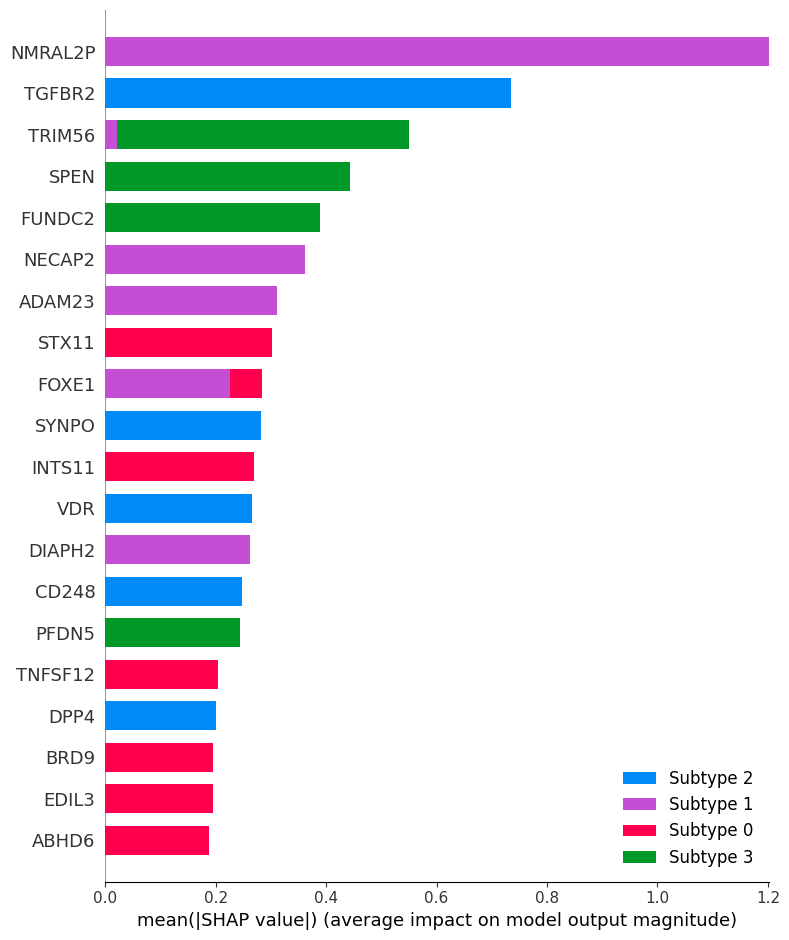

In [59]:
# a. Identify genes uniquely up/down-regulated in each cluster
print("\n Biomarkers for Cluster 0:")
cluster0_indices = tumor_normalized_df[tumor_normalized_df['Cluster'] == 0].index
other_indices = tumor_normalized_df[tumor_normalized_df['Cluster'] != 0].index

# Use the log-transformed (but not Z-scored) tumor data for biological interpretation
cluster0_expr = df_log_transformed.loc[:, cluster0_indices]
other_expr = df_log_transformed.loc[:, other_indices]

# A simple t-test can find initial candidates
biomarker_results = pd.DataFrame(index=cluster0_expr.index)
biomarker_results['p_value'] = ttest_ind(cluster0_expr, other_expr, axis=1, equal_var=False).pvalue
biomarker_results['log2FC'] = cluster0_expr.mean(axis=1) - other_expr.mean(axis=1)
biomarker_results['FDR'] = fdrcorrection(biomarker_results['p_value'])[1]

# Top 5 genes upregulated in Cluster 0
top_biomarkers = biomarker_results.loc[(biomarker_results['FDR'] < 0.05) & (biomarker_results['log2FC'] > 0)].sort_values('log2FC', ascending=False)
print("Top 5 upregulated genes in Cluster 0:")
print(top_biomarkers.head())

# b. Use a feature selection model (XGBoost + SHAP)
X = tumor_normalized_df.drop('Cluster', axis=1)
y = tumor_normalized_df['Cluster']

# Train an XGBoost classifier
model = xgb.XGBClassifier(objective='multi:softprob', random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X, y)

# Explain the model with SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Visualize the most predictive genes overall
shap.summary_plot(shap_values, X, plot_type="bar", max_display=20, class_names=[f'Subtype {i}' for i in range(OPTIMAL_K)])

#Build a Subtype Classifier


Classifier Accuracy: 0.9205

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.90      0.98      0.93        44
           2       0.92      0.98      0.95        61
           3       1.00      0.64      0.78        14

    accuracy                           0.92       151
   macro avg       0.94      0.86      0.89       151
weighted avg       0.92      0.92      0.92       151



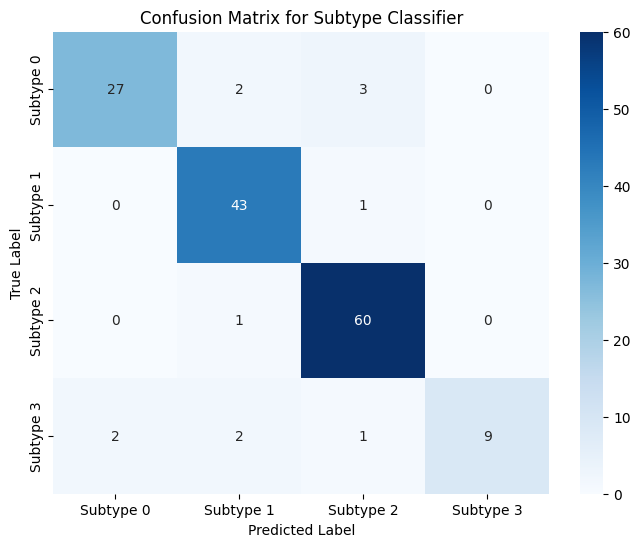

In [60]:
X = tumor_normalized_df.drop('Cluster', axis=1)
y = tumor_normalized_df['Cluster']

# a. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# b. Train a Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# c. Make predictions and evaluate
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nClassifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# d. Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Subtype {i}' for i in range(OPTIMAL_K)], 
            yticklabels=[f'Subtype {i}' for i in range(OPTIMAL_K)])
plt.title('Confusion Matrix for Subtype Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Biological Characterization

Finding Unique Biomarkers and Pathways for Each Subtype

 Analyzing Subtype 0
Top 5 upregulated biomarkers for Subtype 0:


,log2FC,p_value,FDR
0,,,
H19,1.470440,2.981392e-06,1.325063e-05
PADI3,1.442010,1.048713e-08,7.716799e-08
ADH1C,1.296833,7.673362e-05,2.570306e-04
FOXA1,1.236561,8.088854e-12,1.210906e-10
FGFR3,1.132004,4.705100e-10,4.695709e-09



Top enriched pathways for Subtype 0:


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Calcium signaling pathway,2/240,0.003828,0.0719,0,0,27.666667,153.973647,NOS2;FGFR3
1,KEGG_2021_Human,Arginine biosynthesis,1/22,0.008768,0.0719,0,0,135.857143,643.513035,NOS2
2,KEGG_2021_Human,Tyrosine metabolism,1/36,0.014312,0.0719,0,0,81.457143,345.920719,ADH1C
3,KEGG_2021_Human,Bladder cancer,1/41,0.016286,0.0719,0,0,71.257143,293.399847,FGFR3
4,KEGG_2021_Human,Fatty acid degradation,1/43,0.017074,0.0719,0,0,67.857143,276.192230,ADH1C



 Analyzing Subtype 1
Top 5 upregulated biomarkers for Subtype 1:


,log2FC,p_value,FDR
0,,,
NMRAL2P,4.036394,2.097473e-94,2.097473e-90
AKR1B10,3.750579,3.975038e-45,9.695214e-43
AKR1C1,3.591652,1.237180e-71,3.092950e-68
CYP4F11,3.534628,4.236934e-58,3.259180e-55
CYP4F3,3.402567,5.724737e-58,4.089098e-55



Top enriched pathways for Subtype 1:


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Glutathione metabolism,12/57,3.438883e-12,6.396323e-10,0,0,22.755556,600.652786,GSTM4;GSTM3;G6PD;GPX2;GSTM2;GCLC;GSTA4;ODC1;GS...
1,KEGG_2021_Human,Metabolism of xenobiotics by cytochrome P450,13/76,7.067378e-12,6.572661e-10,0,0,17.668875,453.657761,GSTM4;CBR1;GSTM3;GSTM2;AKR1C1;ADH7;ALDH3A1;GST...
2,KEGG_2021_Human,Drug metabolism,10/108,7.958884e-07,4.867419e-05,0,0,8.609530,120.910572,GSTM4;ALDH3A1;GSTM3;GSTM2;GSTA4;GSTA1;ADH7;UGT...
3,KEGG_2021_Human,Hepatocellular carcinoma,12/168,1.046757e-06,4.867419e-05,0,0,6.527140,89.877497,GSTM4;GSTM3;NQO1;GSTM2;WNT11;GSTA4;FZD7;TXNRD1...
4,KEGG_2021_Human,Pathways in cancer,19/531,2.866085e-05,1.066184e-03,0,0,3.188259,33.349116,GSTM4;GSTM3;NQO1;GSTM2;FZD7;TXNRD1;WNT5A;CALML...



 Analyzing Subtype 2
Top 5 upregulated biomarkers for Subtype 2:


,log2FC,p_value,FDR
0,,,
IGHA1,2.121254,6.730130e-27,9.257400e-26
IGHV5-51,2.093632,2.045956e-24,2.278347e-23
IGHV1-18,2.080689,5.154974e-25,6.043346e-24
IGHA2,2.057974,7.067346e-25,8.160908e-24
MMP13,2.010766,6.279896e-20,4.630044e-19



Top enriched pathways for Subtype 2:


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Staphylococcus aureus infection,32/95,8.246209e-28,1.764689e-25,0,0,21.188364,1321.362103,C1QB;C1QA;ITGAM;SELPLG;C1S;CFH;C1R;ITGB2;C5AR1...
1,KEGG_2021_Human,Phagosome,34/152,6.116955e-23,6.545141e-21,0,0,12.037113,615.678973,COLEC12;ITGAM;SFTPA2;C1R;NCF4;ITGB2;THBS2;CORO...
2,KEGG_2021_Human,Complement and coagulation cascades,22/85,9.720666e-17,6.934075e-15,0,0,14.260971,525.797617,C1QB;C1QA;ITGAM;SERPINA1;C1S;CFH;C1R;ITGB2;SER...
3,KEGG_2021_Human,Protein digestion and absorption,22/103,7.718198e-15,3.453067e-13,0,0,11.081596,360.098615,CPA3;COL15A1;COL16A1;COL14A1;ELN;COL11A1;COL12...
4,KEGG_2021_Human,Tuberculosis,28/180,8.860738e-15,3.453067e-13,0,0,7.583987,245.396163,ITGAM;ITGB2;LSP1;CORO1A;CTSS;C3;MRC2;FCGR3A;HL...



 Analyzing Subtype 3
Top 5 upregulated biomarkers for Subtype 3:


,log2FC,p_value,FDR
0,,,
CXCL8,2.139015,2.587432e-08,1.509587e-07
RPS7P1,1.980809,3.247810e-21,3.247810e-18
AC020898.1,1.736332,3.068559e-19,1.278566e-16
RPS3A,1.678048,3.042091e-18,6.613242e-16
AC024293.1,1.675990,1.232338e-20,1.026949e-17



Top enriched pathways for Subtype 3:


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Ribosome,19/158,7.562965e-18,1.119319e-15,0,0,20.726508,817.106688,RPS7;RPS5;RPS6;RPSA;RPS3A;RPL9;MRPL11;RPS14;RP...
1,KEGG_2021_Human,Coronavirus disease,20/232,7.161360e-16,5.299407e-14,0,0,14.362293,500.851397,CXCL8;RPS7;RPS5;RPS6;RPSA;RPS3A;RPL9;CXCL10;RP...
2,KEGG_2021_Human,Oxidative phosphorylation,10/133,5.998904e-08,2.959459e-06,0,0,11.538866,191.881011,COX7A2L;COX7B;ATP6V0B;UQCRQ;NDUFB5;NDUFA4;NDUF...
3,KEGG_2021_Human,Non-alcoholic fatty liver disease,9/155,2.473806e-06,8.834328e-05,0,0,8.676370,112.009790,COX7A2L;COX7B;CXCL8;UQCRQ;NDUFB5;NDUFA4;NDUFA2...
4,KEGG_2021_Human,Diabetic cardiomyopathy,10/203,2.984570e-06,8.834328e-05,0,0,7.327692,93.223303,COX7A2L;COX7B;UQCRQ;MPC1;NDUFB5;NDUFA4;MPC2;ND...



 Generating Biomarker Heatmap


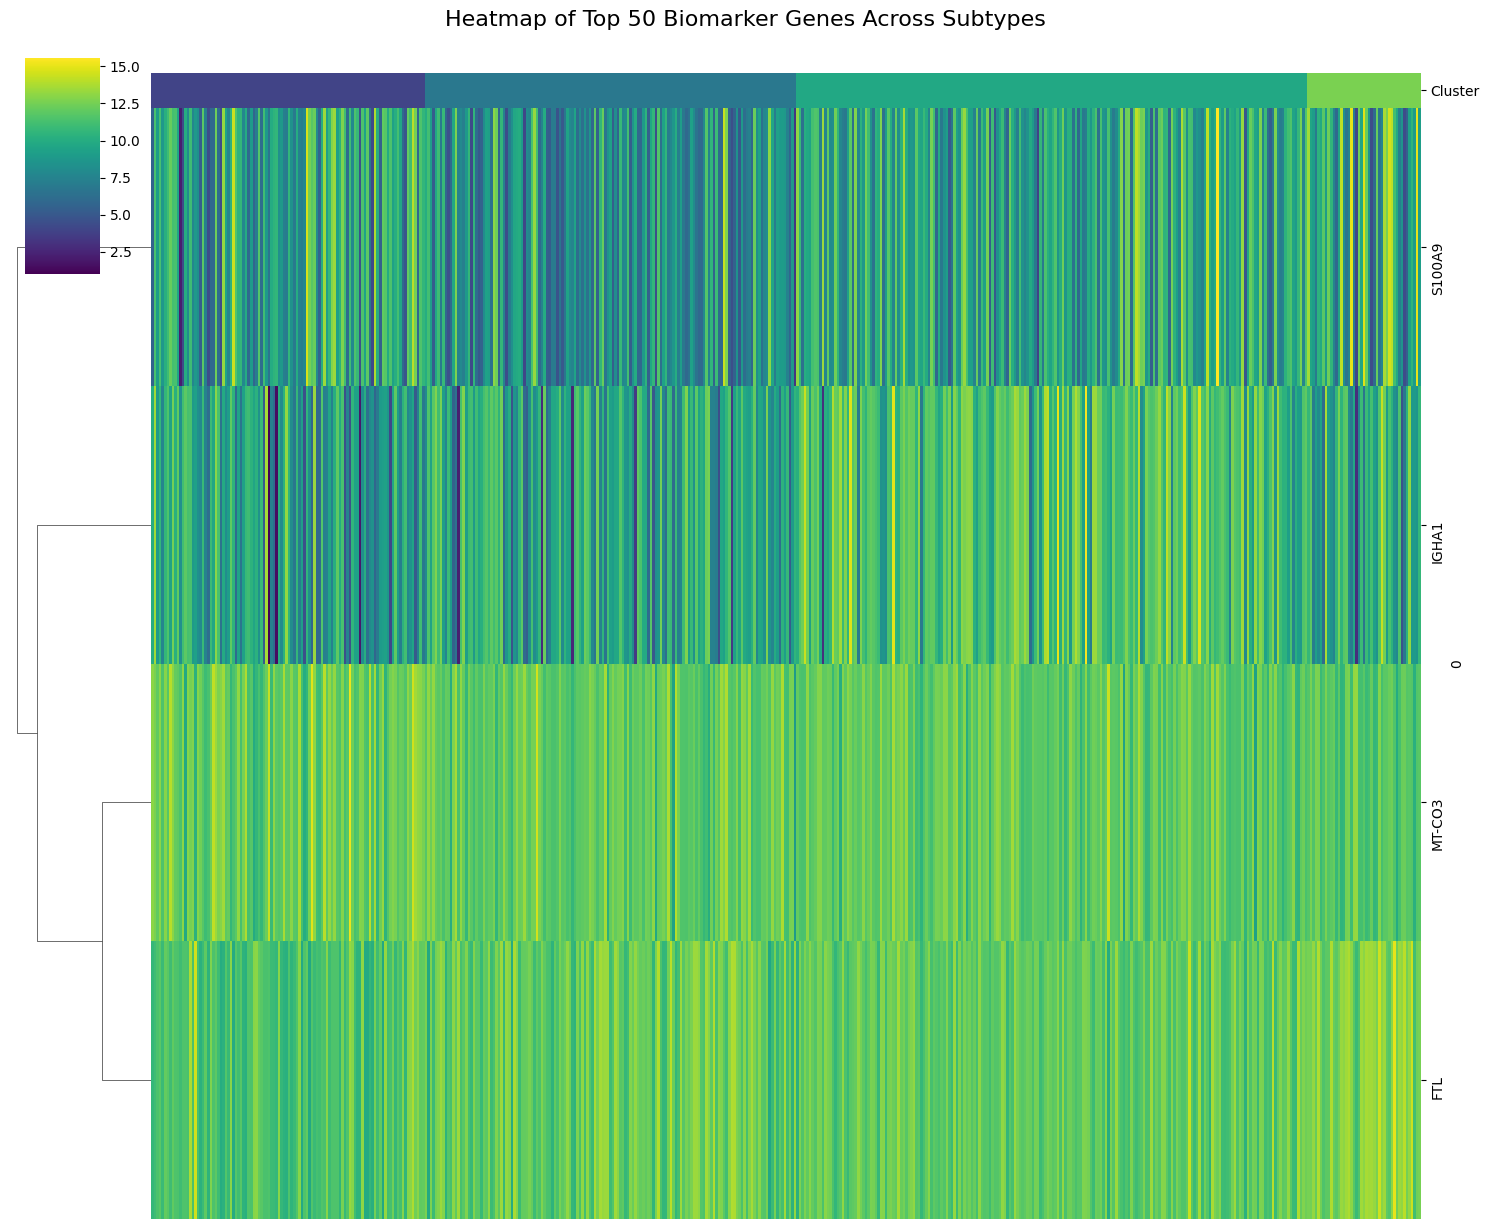

In [68]:
tumor_subtype_df = tumor_normalized_df.copy()
tumor_log_transformed_df = df_log_transformed.loc[:, sample_types == 'tumor']

print("Finding Unique Biomarkers and Pathways for Each Subtype")

# A dictionary to store the unique genes for each subtype
subtype_biomarkers = {}

for i in range(OPTIMAL_K):
    print(f"\n Analyzing Subtype {i}")
    
    subtype_indices = tumor_subtype_df[tumor_subtype_df['Cluster'] == i].index
    other_indices = tumor_subtype_df[tumor_subtype_df['Cluster'] != i].index

    subtype_expr = tumor_log_transformed_df.loc[:, subtype_indices]
    other_expr = tumor_log_transformed_df.loc[:, other_indices]

    p_values = ttest_ind(subtype_expr, other_expr, axis=1, equal_var=False).pvalue
    log2fc = subtype_expr.mean(axis=1) - other_expr.mean(axis=1)
    
    subtype_de_results = pd.DataFrame({'log2FC': log2fc, 'p_value': p_values}, index=subtype_expr.index)
    subtype_de_results.dropna(inplace=True)
    subtype_de_results['FDR'] = fdrcorrection(subtype_de_results['p_value'])[1]

    upregulated_biomarkers = subtype_de_results[
        (subtype_de_results['FDR'] < 0.05) & 
        (subtype_de_results['log2FC'] > 1.0) 
    ].sort_values('log2FC', ascending=False)
    
    print(f"Top 5 upregulated biomarkers for Subtype {i}:")
    display(upregulated_biomarkers.head())
    
    subtype_biomarkers[i] = upregulated_biomarkers.index.tolist()

    if subtype_biomarkers[i]:
        print(f"\nTop enriched pathways for Subtype {i}:")
        enriched_pathways = gp.enrichr(
            gene_list=subtype_biomarkers[i],
            gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
            organism='human',
            outdir=None
        )
        display(enriched_pathways.results.head())
    else:
        print(f"\n No significant upregulated biomarkers found for Subtype {i} to analyze.")

# Create a Biomarker Heatmap
print(f"\n Generating Biomarker Heatmap")

shap_means = np.abs(shap_values).mean(1).mean(0)

top_shap_genes = X.columns[np.argsort(shap_means)[-50:]]

sorted_samples = tumor_subtype_df.sort_values('Cluster').index
heatmap_data = tumor_log_transformed_df.loc[top_shap_genes, sorted_samples]

cluster_colors = tumor_subtype_df.loc[sorted_samples, 'Cluster']
palette = sns.color_palette('viridis', OPTIMAL_K)
cluster_lut = dict(zip(range(OPTIMAL_K), palette))
col_colors = cluster_colors.map(cluster_lut)

g = sns.clustermap(
    heatmap_data,
    col_cluster=False, 
    row_cluster=True,
    col_colors=col_colors,
    cmap='viridis',
    xticklabels=False,
    figsize=(15, 12),
    dendrogram_ratio=(.1, .02)
)
g.fig.suptitle('Heatmap of Top 50 Biomarker Genes Across Subtypes', y=1.02, fontsize=16)
plt.show()

#Address Classifier Imbalance

\nIMPROVED Classifier Accuracy: 0.9007
\nIMPROVED Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        32
           1       0.89      0.91      0.90        44
           2       0.87      0.98      0.92        61
           3       1.00      0.71      0.83        14

    accuracy                           0.90       151
   macro avg       0.93      0.85      0.88       151
weighted avg       0.91      0.90      0.90       151



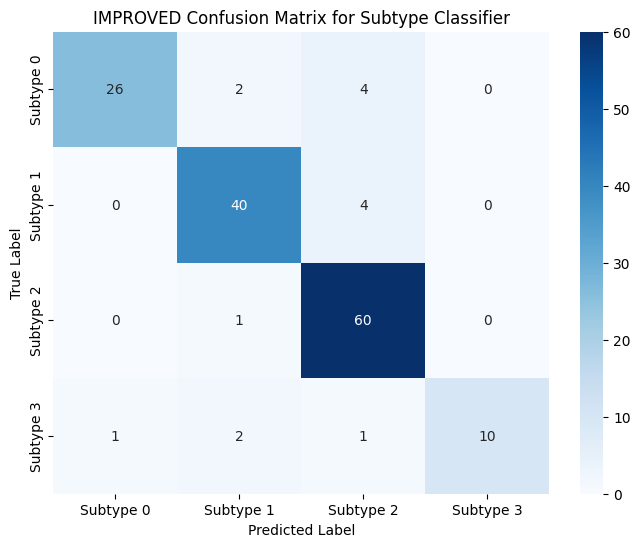

In [70]:
X = tumor_subtype_df.drop('Cluster', axis=1)
y = tumor_subtype_df['Cluster']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest model WITH class_weight='balanced'
rf_classifier_balanced = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'
)
rf_classifier_balanced.fit(X_train, y_train)

# Evaluate the new model
y_pred_balanced = rf_classifier_balanced.predict(X_test)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)

print(f"\\nIMPROVED Classifier Accuracy: {accuracy_balanced:.4f}")
print("\\nIMPROVED Classification Report:")
print(classification_report(y_test, y_pred_balanced))

# Plot the new confusion matrix
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Subtype {i}' for i in range(OPTIMAL_K)], 
            yticklabels=[f'Subtype {i}' for i in range(OPTIMAL_K)])
plt.title('IMPROVED Confusion Matrix for Subtype Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()